In [1]:
import numpy as np

In [8]:
import sys, os
ROOT = "~/ThereminData/logs/orange_squares"
root = os.path.expanduser(ROOT)
p = os.path.expanduser("~/ThereminData/logs")
print p
sys.path.append(p)

/home/kerem/ThereminData/logs


In [9]:
files = !ls $ROOT/*phase*.*

In [10]:
blacklist = []
files = [".".join((f.split('.')[:-1])) for f in files]
files = filter(lambda x: x.split(".")[-1] in ('xy', 'amp_and_freq', 'amp_and_mel'), files)
files = filter(lambda x: not any([el in x for el in blacklist]), files)
file_to_id = lambda f: ".".join(f.split('/')[-1].split('.')[:2])
files_xy = filter(lambda x: x.split(".")[-1] in ('xy',), files)
files_amp_and_mel = filter(lambda x: x.split(".")[-1] in ('amp_and_mel',), files)
files_amp_and_freq = filter(lambda x: x.split(".")[-1] in ('amp_and_freq',), files)
# files_iconicity
# for f in files:
#     print f
# print files
ids = [file_to_id(f) for f in files]
# print ids
print len(files), "files"
print files_xy[0], files_amp_and_mel[0], files_amp_and_freq[0], files[0]
print len(files_xy), len(files_amp_and_mel), len(files_amp_and_freq)

from collections import defaultdict
d = defaultdict(int)
dd = defaultdict(list)
from os.path import basename
for f in files:
    id = basename(f).split('.')[0]
    d[id] += 1
    dd[id].append(basename(f))
print d
print dd['D12300311014']
del d, dd
# print dd
assert len(files_xy) == len(files_amp_and_mel) == len(files_amp_and_freq)
# files_xy = files_xy[:2]
# files_amp_and_freq = files_amp_and_freq[:2]
# files_amp_and_mel = files_amp_and_mel[:2]

207 files
/home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.xy /home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.amp_and_mel /home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.amp_and_freq /home/kerem/ThereminData/logs/orange_squares/OS10.1.exp.log.phase0.amp_and_freq
69 69 69
defaultdict(<type 'int'>, {'OS15': 9, 'OS17': 9, 'OS16': 9, 'OS11': 9, 'OS10': 9, 'OS13': 9, 'OS19': 9, 'OS18': 9, 'OS9': 9, 'OS8': 9, 'OS1': 9, 'OS3': 9, 'OS2': 9, 'OS5': 9, 'OS4': 9, 'OS7': 9, 'OS6': 9, 'OS24': 9, 'OS25': 9, 'OS20': 9, 'OS21': 9, 'OS22': 9, 'OS23': 9})
[]


In [17]:
from StreamlinedDataAnalysisGhmm import unpickle_results
import pandas as pd

d = pd.read_csv("/shared/AudioData/ThereminData/logs/logs/discrete/discretesurfacedata2.csv", na_values=["NaN"])

In [5]:
def pick_lowest_bic(hmms):
    hmm, bic = None, 99999999999999
    for h in hmms:
        if h is None:
            continue
        if h.bic < bic:
            hmm = h
            bic = h.bic
    if hmm == None:
        print f, hmms
    return (hmm, bic)

def hmm_to_pykov_chain(hmm):
    from pykov import Chain
    chain = Chain()
    alphabet = [str(i) for i in range(hmm.nstates)]
    for r, row in enumerate(hmm.transmat):
        for c, cell in enumerate(row):
            chain[str(r), str(c)] = cell
    return chain

In [18]:
import pandas as pd
from matplotlib.pyplot import *
from rpy2.rinterface import RRuntimeError
pd.set_option('mode.chained_assignment','warn')
pd.set_option("display.max_rows", 300)
# import the surface data
# d = pd.read_csv("/shared/AudioData/ThereminData/surfacedata.csv", na_values=["NaN"])


da_dict = {}
states_xy = []
bics_xy = []
hmms_xy = []
states_freq = []
bics_freq = []
hmms_freq = []
states_mel = []
bics_mel = []
hmms_mel = []
phases = []
entropies_xy = []
entropies_freq = []
entropies_mel = []
llhs_xy = []
llhs_freq = []
llhs_mel = []
total_score = []
cols = ['id', 'reversed', 'condition', 'phase', 'phase_order', 'score', 'score_n', 'total_score','discrete']
# add a 5 
for u in ('xy', 'amp_and_freq', 'amp_and_mel'):
    for c in ("nstates_%s", "bic_%s", "nstates_%s_n", "bic_%s_n"):
        cols.append(c % u)
    
# print cols
all_data = pd.DataFrame(index=range(len(files_xy)),columns = tuple(cols))
score_cols = ["Test1", "Test2", "Test3"]
series = lambda x: pd.Series(x, index=all_data.index)
normalize = lambda x: (x - np.average(x)) / np.std(x)
norm_series = lambda x: series(normalize(x))

all_data["id"] = series([file_to_id(f).split(".")[0] for f in files_xy])
all_data["phase"] = series([int(f.split(".")[-2][-1]) for f in files_xy])
all_data["phase"] = series([int(f.split(".")[-2][-1]) for f in files_xy])
all_data["phase_order"] = series([int(f.split(".")[-2][-1]) for f in files_xy])

# for f in files:
#     print f
#     print any([True if hmm is not None else False for hmm in unpickle_results(f).hmms])

hmms_xy = [pick_lowest_bic(unpickle_results(f).hmms)[0] for f in files_xy]
hmms_freq = [pick_lowest_bic(unpickle_results(f).hmms)[0] for f in files_amp_and_freq]
hmms_mel = [pick_lowest_bic(unpickle_results(f).hmms)[0] for f in files_amp_and_mel]

def process_hmm(hmm, states, bics, llhs, i=None):
    states.append(hmm.nstates)
    bics.append(hmm.bic)
    llhs.append(np.product(hmm.loglikelihood))

# print hmms
for i, (hmm_xy, hmm_freq, hmm_mel) in enumerate(zip(hmms_xy, hmms_freq, hmms_mel)):
    process_hmm(hmm_xy, states_xy, bics_xy, llhs_xy, i)
    process_hmm(hmm_freq, states_freq, bics_freq, llhs_freq, i)
    process_hmm(hmm_mel, states_mel, bics_mel, llhs_mel, i)
    
# print "States:",states_xy, states_freq, states_mel     
# all_data["entropy_xy"] = series(entropies_xy)
# all_data["entropy_amp_and_freq"] = series(entropies_freq)
# all_data["entropy_amp_and_mel"] = series(entropies_mel)
assert len(bics_xy) == len(all_data)
all_data["bic_xy"] = series(bics_xy)
all_data["bic_amp_and_freq"] = series(bics_freq)
all_data["bic_amp_and_mel"] = series(bics_mel)
all_data["nstates_xy"] = series(states_xy)
all_data["nstates_amp_and_freq"] = series(states_freq)
all_data["nstates_amp_and_mel"] = series(states_mel)
all_data["llh_xy"] = series(llhs_xy)
all_data["llh_amp_and_freq"] = series(llhs_freq)
all_data["llh_amp_and_mel"] = series(llhs_mel)

cond = []
rev = []
scores = []
discrete = []
for id, phase in zip(all_data["id"], all_data["phase"]):
#     print "ID", id
    
    # this piece of trickery makes sure we don't screw up
    # due to differences in case
    row = d[d["ID"] == id].index.tolist()
    if len(row) < 1:
        row = d[d["ID"] == id.upper()].index.tolist()
    if len(row) < 1:
        row = d[d["ID"] == id.lower()].index.tolist()
    if len(row) < 1:
        print id, phase
        print "FUUUUCK"
    
    row = row[0]

    cond.append(d.at[row,"Condition"])
    rev.append(d.at[row, "Reversed"])
    scores.append(d.at[row, score_cols[phase]])
    total_score.append(d.at[row, "TestAll"])
    discrete.append(d.at[row, "Discrete"])
    
all_data["condition"] = series(cond)
all_data["reversed"] = series(rev)
all_data["score"] = series(scores)
all_data["total_score"] = series(total_score)

# all_data["entropy_xy_n"] = norm_series(entropies_xy)
# all_data["entropy_amp_and_freq_n"] = norm_series(entropies_freq)
# all_data["entropy_amp_and_mel_n"] = norm_series(entropies_mel)
all_data["bic_xy_n"] = norm_series(bics_xy)
all_data["bic_amp_and_freq_n"] = norm_series(bics_freq)
all_data["bic_amp_and_mel_n"] = norm_series(bics_mel)
all_data["nstates_xy_n"] = norm_series(states_xy)
all_data["nstates_amp_and_freq_n"] = norm_series(states_freq)
all_data["nstates_amp_and_mel_n"] = norm_series(states_mel)
all_data["llh_xy_n"] = norm_series(llhs_xy)
all_data["llh_amp_and_freq_n"] = norm_series(llhs_freq)
all_data["llh_amp_and_mel_n"] = norm_series(llhs_mel)
all_data["score_n"] = norm_series(scores)

# fix the differences in phase among conditions
for index, row in all_data.iterrows():
    if row["condition"] == 2:
        p = row["phase"]
        if p == 1:
            all_data.at[index, "phase"] = 2
            all_data.at[index, "phase_order"] = 1
        elif p == 2:
            all_data.at[index, "phase"] = 1
            all_data.at[index, "phase_order"] = 2
        else:
            continue
#         print "Switchover! %s to %s" % (p, all_data.at[index, "phase"]) 
#         print all_data.at[index, "phase"], p
        assert all_data.at[index, "phase"] != p
    
from os.path import join
all_data.to_csv(join(root, "all_scores_bics_nstates_by_phase.csv"))
# print all_data

colors = "Blue BlueViolet Chocolate Crimson Yellow Green DarkSlateBlue DeepPink GreenYellow DarkKhaki Olive LightGray Black".split()

    
# all_data
# figure()

# hist(states)
# figure()
# print bics_freq
# print zip(phases, states), len(states)
# print bics, len(bics)
# print da_dict

DR123016161014 0
FUUUUCK


IndexError: list index out of range

In [ ]:
# print all_data["phase"]
import pandas as pd
from matplotlib.pyplot import *
%matplotlib inline
all_data = pd.read_csv("all_scores_bics_nstates_by_phase.csv")
from matplotlib.patches import Patch
zero = all_data[all_data.phase == 0]
one = all_data[all_data.phase == 1]
two = all_data[all_data.phase == 2]
get_values = lambda x: x["nstates_amp_and_freq"].values
figure(figsize=(15,10))
mappings = ['1:1', "1:2", "2:2"]
colors = [gca()._get_lines.color_cycle.next() for i in mappings] 
# print dir(colors)
# print colors
handles = [Patch(color=c, label=m) for c,m in zip(colors, mappings)]
hist([get_values(zero),get_values(one),get_values(two)], stacked=True, color=colors)#, histtype="stepfilled")
legend(handles=handles)
# # figure()
# # hist(get_values(one), label="1:2")
# # figure()
# # hist(get_values(two), label="2:2")
# legend()
# print one
# hist(one["nstates_amp_and_freq"])
# figure()
# hist(two["nstates_amp_and_freq"])
# # %matplotlib qt
# # x = "llh"
# # y = "bic"
# # from matplotlib.pyplot import scatter
# # scat = lambda x, y: plt.scatter(all_data[x], all_data[y])
# # scat(x,y)
# # xlabel(x)
# # ylabel(y)
# import StreamlinedDataAnalysis
# print plt
# def plot_hmm(hmm):
#     StreamlinedDataAnalysis.plot_hmm(means_=hmm.means, transmat=hmm.transmat, covars=hmm.variances, initProbs=hmm.initProb)
# plot_hmm(hmms[10])

In [57]:
from rpy2.robjects import r
from rpy2 import robjects
from rpy2.robjects import globalenv
print (all_data[all_data.phase == 0]["nstates_amp_and_freq"])

0     14
3     11
6     22
9      9
12    16
15    15
18    12
21    15
24    17
27    14
30     9
33    23
36    13
39     9
42     9
45    10
48    15
51    16
54    27
57    14
60    15
63    21
Name: nstates_amp_and_freq, dtype: int64


0    -7.953146e+19
1     5.146308e+29
2    -1.845962e+34
3     1.466155e+18
4     2.974465e+30
5     2.429267e+34
6    -9.601521e+22
7     3.720090e+35
8     4.129149e+40
9     4.103251e+20
10    3.103916e+31
11    1.125560e+39
12    4.709132e+23
13    5.122049e+38
14    1.715081e+44
15    9.806089e+21
16    5.758187e+31
17    2.077187e+33
18    1.341970e+22
19    9.814284e+31
20    4.266219e+36
21    1.687628e+22
22    3.307053e+36
23    4.711220e+39
24    3.108171e+21
25    1.475275e+32
26    1.219394e+31
27    1.376986e+21
28    7.170022e+38
29    6.557118e+40
30    1.693922e+19
31    3.761372e+36
32    2.380462e+32
33    2.008097e+22
34    4.065373e+39
35   -4.836495e+31
36    2.199131e+21
37    1.206093e+40
38    4.676965e+36
39    4.447998e+19
40    2.332517e+28
41    1.212791e+20
42    1.805390e+19
43    3.564156e+39
44    9.114682e+30
45    2.440110e+20
46    1.121816e+40
47    1.094578e+35
48   -6.186376e+18
49   -3.380008e+32
50    5.476993e+30
51    3.472066e+23
52    8.9669

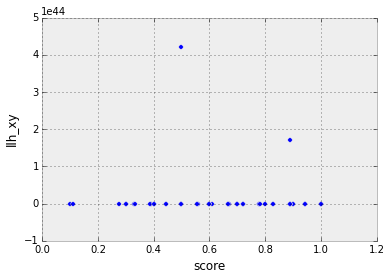

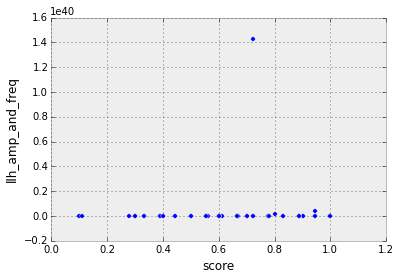

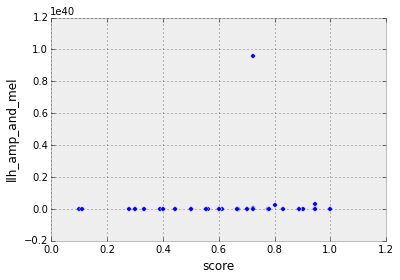

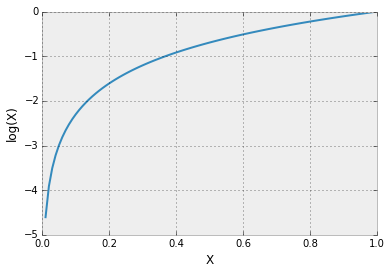

In [79]:
# %matplotlib inline
# print all_data['llh']
# scatter(all_data["score"], all_data["llh"])
def plot_trend(target_col, source_col):
    for unit in ("xy", "amp_and_freq", "amp_and_mel"):
        figure()
        scatter(all_data[target_col], all_data["%s_%s" % (source_col, unit)])
        xlabel(target_col)
        ylabel("%s_%s" % (source_col, unit))

plot_trend("score", "llh")

figure()
plot(np.divide(range(1,100),100.), np.log(np.divide(range(1,100),100.)))
xlabel("X")
ylabel("log(X)")
print all_data["llh_xy"]
# print ids

In [16]:
print d[d["ID"]=="D132011151014"]

Empty DataFrame
Columns: [ID, Age, Sex, Musical, Discrete, Condition, Reversed, Easy, Strategy1, Strategy1_1, Stategy1_2, Strategy2_1, Strategy2_2, same, strategy, Test1, Test2, Test3, TestAll]
Index: []
